<h3>Algorithmic Machine Learning Challenge</h3>
<h1>Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

Plankton comprises all the organisms freely drifting with ocean currents. These life forms are a critically important piece of oceanic ecosystems, accounting for more than half the primary production on earth and nearly half the total carbon fixed in the global carbon cycle. They also form the foundation of aquatic food webs, including those of large, commercially important fisheries. Loss of plankton populations could result in ecological upheaval as well as negative societal impacts, particularly in indigenous cultures and the developing world. Plankton’s global significance makes their population levels an ideal measure of the health of the world’s oceans and ecosystems.

Traditional methods for measuring and monitoring plankton populations are time consuming and cannot scale to the granularity or scope necessary for large-scale studies. Improved approaches are needed. One such approach is through the use of underwater imagery sensors. 

In this challenge, which was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS, plankton images were acquired in the bay of Villefranche, weekly since 2013 and manually engineered features were computed on each imaged object. 

This challenge aims at developing solid approaches to plankton image classification. We will compare methods based on carefully (but manually) engineered features, with “Deep Learning” methods in which features will be learned from image data alone.

The purpose of this challenge is for you to learn about the commonly used paradigms when working with computer vision problems. This means you can choose one of the following paths:

- Work directly with the provided images, e.g. using a (convolutional) neural network
- Work with the supplied features extracted from the images (*native* or *skimage* or both of them)
- Extract your own features from the provided images using a technique of your choice

You will find a detailed description about the image data and the features at the end of this text.
In any case, the choice of the classifier that you decide to work with strongly depends on the choice of features.

Please bear in mind that the purpose of this challenge is not simply to find the best-performing model that was released on e.g. Kaggle for a similar problem. You should rather make sure to understand the dificulties that come with this computer vision task. Moreover, you should be able to justify your choice of features/model and be able to explain its advantages and disadvantages for the task.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

In [1]:
!pip3 install --user 'keras'

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from random import randint
    
from scipy.stats import norm
import scipy.ndimage
meta = pd.read_csv('/mnt/datasets/plankton/flowcam/meta.csv')




In [2]:
import zipfile
from io import BytesIO
from PIL import Image

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


img_files = extract_zip_to_memory("/mnt/datasets/plankton/flowcam/imgs.zip")

# Display an example image 
Image.open(img_files['imgs/32738710.jpg'])

# Load the image as a numpy array:
np_arr = np.array(Image.open(img_files['imgs/32738710.jpg']))

# Be aware that the dictionary will occupy roughly 2GB of computer memory!
# To free this memory again, run:
# del img_files

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.

What is new in this challenge is that you will be working with image data. Therefore, you should have a look at example images located in the *imgs.zip* file (see description below). If you decide to work with the native or the skimage features, make sure to understand them!

Among others, this section should investigate:

- Distribution of the different image dimensions (including the number of channels)
- Distribution of the different labels that the images are assigned to

The image labels are organized in a taxonomy. We will measure the final model performance for the classification into the *level2* categories. Make sure to understand the meaning of this label inside the taxonomy.

In [3]:
meta.head()

,objid,projid,id,status,latitude,longitude,objdate,objtime,depth_min,depth_max,unique_name,lineage,level1,level2
0,32756761.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
1,32759364.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
2,32758055.0,133,28299,V,43.683333,7.3,2013-09-19,00:09:00,0,75,Guinardia,/#/living/Eukaryota/Harosa/Stramenopiles/Ochro...,Guinardia,Rhizosolenids
3,32758988.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks
4,32760598.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks


In [4]:
#Starting to familiarizing with the given data by fiding its len
print("In our data set we have about" , len(img_files) , "images")


In our data set we have about 243610 images


In [5]:
print("Number of different level2 is: ", meta.level2.unique().size)

Number of different level2 is:  40


In [6]:
#Identifying the different level twos that are less present and we have to do data augmentatiin on it
different_species = meta.groupby(['level2'])['objid'].count()
print(different_species.sort_values(ascending=True))

#taking the 30 less represented level2
little_class = different_species.sort_values(ascending=True)[:30]

level2
Bacteriastrum                         12
Xystonellidae                         37
tempChaetoceros danicus               61
Lithodesmioides                       68
Cyttarocylis                         100
Asterionellopsis                     117
Odontella (Mediophyceae)             131
centric                              145
Ceratocorys horrida                  186
Pleurosigma                          191
Retaria                              257
Coscinodiscids                       334
Stenosemella                         357
Rhabdonella                          367
Annelida                             481
Dinophysiales                        525
Dictyocysta                          549
Hemiaulus                            670
egg (other)                          685
Undellidae                           710
chainlarge                           751
Codonaria                            845
pollen                              1821
artefact                            1849
Chaetocer

__COMMENTS__ :

As we can see we have about 40 different level two, and some are more present than others.
Indeed a few are less present and some are very present. This is interesting to notify because 
in data augmentation we will focus to increase the data size of this level two especially.


In [7]:
#Printing null value and droping it 
null_columns=meta.columns[meta.isnull().any()]
print(meta[null_columns].isnull().sum())

meta =  meta.dropna(subset=['level2'])
print(meta[null_columns].isnull().sum())

level1    3334
level2    1003
dtype: int64
level1    2618
level2       0
dtype: int64


__COMMENTS__ :

Here in this cell, we delete the null column because some level 2 are Null ie non described for instance.


In [8]:
little_class = list(little_class.index.sort_values(ascending=True)[:70])
print(little_class)

['Annelida', 'Asterionellopsis', 'Bacteriastrum', 'Ceratocorys horrida', 'Chaetoceros', 'Codonaria', 'Codonellopsis (Dictyocystidae)', 'Coscinodiscids', 'Cyttarocylis', 'Dictyocysta', 'Dinophysiales', 'Hemiaulus', 'Lithodesmioides', 'Odontella (Mediophyceae)', 'Pleurosigma', 'Protoperidinium', 'Retaria', 'Rhabdonella', 'Rhizosolenids', 'Stenosemella', 'Tintinnidiidae', 'Undellidae', 'Xystonellidae', 'artefact', 'centric', 'chainlarge', 'egg (other)', 'multiple (other)', 'pollen', 'tempChaetoceros danicus']


In [9]:
#Dropping useless columns
meta = meta.drop(['longitude', 'objdate' ,'objtime' , 'depth_max' , 'depth_min' , 'level1', 'unique_name' , 'lineage', 'id' , 'projid', 'status', 'latitude'] ,axis=1)

In [10]:
meta.head()

,objid,level2
0,32756761.0,detritus
1,32759364.0,detritus
2,32758055.0,Rhizosolenids
3,32758988.0,silks
4,32760598.0,silks


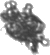

In [12]:
#Display an example image 
Image.open(img_files['imgs/32738710.jpg'])


In [13]:
#Working on the different size of the initial images
img_list = np.array(list(img_files.values()))
img_shape_list=[]

for i in range (len(img_list)):
    np_arr = np.array(Image.open(img_list[i]))
    img_shape_list+= [np_arr.shape]
    
print('The max is ' , max(img_shape_list))
print("The min is" , min(img_shape_list))


The max is  (739, 198)
The min is (2, 7)


,0,1
count,243610.000000,243610.000000
mean,109.338582,86.628936
std,71.930568,62.146386
min,2.000000,2.000000
25%,61.000000,49.000000
50%,87.000000,67.000000
75%,135.000000,104.000000
max,739.000000,972.000000


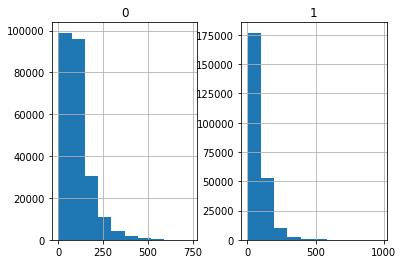

In [14]:
size_DF = pd.DataFrame(img_shape_list)
size_DF.hist()
size_DF.describe()

__COMMENTS__:

So, as we can see, in the distributions of the size of the image on x and y. The distribution is quite on the little value,
as we can see about 50% of the image are less than 87 on X and less than 49 on Y.
This two histograms will permit us to choose and size to resize our images in the next part to create a standard 'size' and 
avoid our CNN to learn from the size of the images

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data based on your approach:

- If you decide to work with the provided features, some data cleaning may be required to make full use of all the data.
- If you decide to extract your own features from the images, you should explain your approach in this section.
- If you decide to work directly with the images themselves, preprocessing the images may improve your classification results. In particular, if you work with a neural network the following should be of interest to you:

  - Due to the fully-connected layers (that usually come after the convolutional ones), the input needs to have a fixed dimension.
  - Data augmentation (image rotation, scaling, cropping, etc. of the existing images) can be used to increase the size of the training data set. This may improve performance especially when little data is available for a particular class.
  - Be aware of the computational cost! It might be worth rescaling the images to a smaller size!

  All of the operations above are usually realized using a dataloader. This means that you do not need to create a modified version of the dataset and save it to disk. Instead, the dataloader processes the data "on the fly" and in-memory before passing it to the network.
  
    NB: Although aligning image sizes is necessary to train CNNs, this will prevent your classifier from learning about different object sizes as a feature. Additional gains may be achieved when also taking object sizes into account.

__COMMENTS__:
    
In this part we will do preprocessing, resizing, scaling, rotating, and creating the list in a formal way to be passed in as the training set to our CNN

In [15]:
img_files = extract_zip_to_memory("/mnt/datasets/plankton/flowcam/imgs.zip")

In [16]:
#THE AIM OF THIS CELL IS TO PERFORM IMAGE RESIZING AND INCREASE THE 
#DATASET SIZE FOR THE CATEGORIES WHICH ARE NOT WELL PRESENT IN THE DATAST
IMG_SIZE = 60

j=0
i=0
img_arrays = {}


# the data, split between train and test sets
train_ids, test_ids, train_labels, test_labels = train_test_split(meta.objid, meta.level2,stratify=meta.level2, test_size=0.4, random_state=2)


x_train, x_test = [] , []

 ###FOR EACH IMAGE OF THE TRAINING SET :  IE EACH LINE OF OUR DATAFRAME , WE RESIZE AND PERFORM DATA AUGMENTATION
for img_id in train_ids:
    
    #Select the image, performs resizing and add it to our list of image in numpy
    img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img = np.array(img)
    img = np.divide((img),255)
    img = img.astype('float32')
    x_train.append(img.reshape(IMG_SIZE,IMG_SIZE,1))
    #If this image is a part of the less representative class
    if ( list(meta.loc[meta['objid'] == img_id, 'level2'])[0] in little_class): 

        #Getting the specie corresponding to this image to add a corresponding line to the meta
        specie = list(meta.loc[meta['objid'] == img_id, 'level2'])[0]
         
        #Flipping left right
        img_arrays[j]=  np.fliplr(img)
        

        #Flipping Up Down
        img_arrays[j+1]=  np.flipud(img)


        #Rotating two times with two different angle  
        img_arrays[j+2]= scipy.ndimage.rotate(img, float(randint(-30,30)), reshape=False, order=5, mode='nearest')
        
        img_arrays[j+3]= scipy.ndimage.rotate(img, float(randint(-30,30)), reshape=False, order=5, mode='nearest')
        

        #Adding a three new lines in our df (one for each modification) with the unique_name corresponding to the original image
        df = pd.DataFrame({'objid' :[j,j+1,j+2,j+3], 'level2' :[specie , specie ,specie ,specie]})
        meta = meta.append(df, ignore_index=True)  
        j+=4
       
    #To track how our program is advancing
    i+=1
    if (i%10000==0):
        print(i)
                


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


__COMMENTS__ :


In the cells after we realised what is called 'Data Augmentation'. Indeed, n is a way of creating new 'data' with different
orientations.The benefits of this are two fold, the first being the ability to generate 'more data' from limited
data and secondly it prevents over fitting. We choose to increase only the less present level2 ie the 30 first in term of 
size. For this, we realise first the split between training data and validation data, because we want to increase only the 
training set and not the validation set. The operation we have done to increase our training set are, fliping up/down , 
fliping right/left , and two rotation with a random angle. e

In [17]:
#ADDING THE NEW IMAGES TO THE TRAINING SET (ie adding it to training ids and label)
for i in range (j):
    train_ids= train_ids.append(pd.DataFrame([i]))
    train_labels = train_labels.append(meta.level2.iloc[[i]])

In [18]:
#PERFORMING NORMALIZATION ON THE NEW IMAGES ADDED
for i in range (j):
    img = img_arrays[i].astype('float32')
    x_train.append(img.reshape(IMG_SIZE,IMG_SIZE,1))

In [19]:
##PERFORMING RESIZING AND NORMALIZATION ON THE TEST
for img_id in test_ids:
    #Select the image, performs resizing and add it to our list of image in numpy
    img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img = np.array(img)
    img  = np.divide(img,255)
    img = img.astype('float32')
    x_test.append(img.reshape(IMG_SIZE,IMG_SIZE,1))


In [20]:
del img_files


Text(0.5,1,'New images to increase the dataset (fliplr, flipud, rotation)')

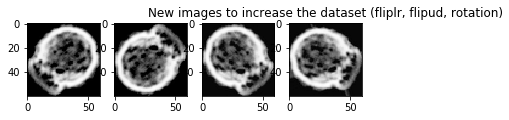

In [21]:
#Plotting the modified version of this image for an example
for i in range (1,5):
    plt.subplot(1,4,i)
    plt.imshow(img_arrays[i-1], cmap='Greys')
plt.title('New images to increase the dataset (fliplr, flipud, rotation)')

In [22]:
#Checking we increase in a correct way 
print('New length of our dataset ' ,len(x_test)+len(x_train) )

#Checking the difference between the size before and after image processing
print('Difference between before and after image processing' ,abs( len(x_train)+ len(x_test) -  (243610 -1003)) )

#Checking our dataframe and our list of img increased in the same way
if(len(meta.index)- len(x_train)- len(x_test) == 0):
    print('we augmented the dataframe and image dataset in the same way')
else:
    print('!!!!!! MISTAKE !!!!!!')

New length of our dataset  260747
Difference between before and after image processing 18140
we augmented the dataframe and image dataset in the same way


<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.

The choice of your model is closely connected to the way you preprocessed the input data.

Furthermore, there are other factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

<h5> Why this model ?</h5>

First of all before deciding to choose to work with a convolutional Neural Network we find it necessary to interest ourselves in all the possibility to do image classification with the raw images after preprocessing. Indeed, Convolutional network although if it's currently a trend, is not the only way to do image classification.

First of all, we decided to use convolutional Neural Network (CNN) because of our dataset. Indeed, the data set size is about 250 000 images, so it is enough to have a performant neural network at the end. CNN requires a lot of dataset because if not it overfit because it can function as highly discriminative features even for considerably different data domains and tasks.

Moreover, we use this methods because it appears to be more more powerfull than others. Indeed, for instance, we could have used Support Vector Machine (SVM). Before CCNs weren't use SVMs were a good solution. For instance, i can train a SVM with 90x90 features where each feature is the pixel value for a 90x90 image, but in this case with pixel vector I lose a lot of spatial interaction between pixels compared to a CNN. It uses adjacent pixel information to effectively downsample the image first by convolution and then uses a prediction layer at the end.

Furthermore, what is interesting with CNN and that there is not much feature selection or preprocessing compared to ther algorithm in image classificaiton like Nearest Neighbours or K-NN, because it we compare handcrafted features with CNN, CNN performance well and it gives better accuracy. It is covering local and global features. It also learns different features from images.

Last, why do I choose this type of CNN, there I'm speaking in term of architecture (number of level, or activation function), we've made several test in the following part, concerning the number of layers. Concerning the activation function, I've tried to make a state of the art and try some activation function at the end too. Indeed, for the activation function, the best for multi class classification is the softmax activation as it gives us the probability to be in the corresponding class. The exponential is not adapted at all, and the sigmoid is made essentially for binary classification, so this is not adapted for our case where we got more than 30 classes.


Moreover, we've decided to take a simple architecture, 3 levels, to avoid overfitting, because a deeper model means better learning on the training set but more overfitting too. We did that in order to avoid to train during 30 minutes/epoch too.


<h5> What is this model's complexity ?</h5>

This model of CNN is a quite complex model in term of number of 'things' ie weight or parameters to train, to choose (number of layers, activation function, etc...)There are about 150 000 trainable parameters according to Keeras sum up of our CNN. Indeed, this is characteristic of Neural Network in general, however thank's to Keeras it is really easy to implement neural networks and we just have to focus on parameters.

<h5> Is it human readable ?</h5>

This is one of the negative point of our algorithm, and of Neural Network in general. This is not human readable very much, especially compared with Decision Tree for instance. However, we care more here on the result and this is the most powerfull machine learning algorithm in this case so human readability does not matter at all.

<h5> Is this model capable of handling different data types ?</h5>

This model is capable of handling black and white images (not colored images) because our CNN is trained on B&W images and not RGB. It can support easily various size of images because our algorithm performs resizing at the beggining to obtain a standard size for the CNNs. 

<h4> Trying various kind of CNNs</h4>

In [19]:
###THE AIM OF THIS PART IS TO IMPLEMENT A FIRST VERSION OF OUR MODEL###
import keras
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D



Using TensorFlow backend.


<h5> Generating the training set and test set</h5>

In [24]:
#For each id in train set add the image corresponding to the list
#Same for the test set

x_train, x_test = np.array(x_train), np.array(x_test)
    
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train shape: (163704, 60, 60, 1)
x_test shape: (97043, 60, 60, 1)


In [25]:
num_classes = meta.level2.unique().size

class_matrix = {}
c = 0
for label in meta.level2.unique():
    class_matrix[label] = c
    c+=1

#Creating y_train and y_test in a categorical form (0 --> [1 , 0 , ... , 0])
y_train, y_test = [], []
for label in train_labels:
    y_train.append(class_matrix[label])
for label in test_labels:
    y_test.append(class_matrix[label])
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (163704, 39)
y_test shape: (97043, 39)


In [26]:
del img_arrays
del meta

In [27]:
import gc
gc.collect()

12

<h5> Generating different model and comparing their efficiency</h5>

In [36]:
##Function to build the CNN for different activation functions
def build_CNN(activation_function , save_file, x_train , y_train , x_test , y_test , epochs , batch_size):
    
    #
    CNN = Sequential()
    CNN.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Conv2D(32, kernel_size=(3, 3), 
                     activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Conv2D(64, kernel_size=(3, 3), 
                     activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    CNN.add(Dense(64, activation='relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(num_classes, activation=activation_function))

    #Different case we may have
    if (activation_function in ['exponential' , 'softmax']):
        print('Using' , activation_function)
        CNN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    else :    
        CNN.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])


    CNN.summary()

    history = CNN.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    
    #Saving in the file to avoid recomputing
    CNN.save(save_file) 
    return(CNN)

In [37]:
#Generating a first test with the sigmoid as activation function
sigmoid_CNN = build_CNN('sigmoid' , 'sigmoid_file.h5', x_train , y_train , x_test , y_test , 2 , 512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
__________

In [38]:
#To test our function on the multi class classification
score=0

y_pred = sigmoid_CNN.predict(x_test)
b = np.zeros_like(y_pred)
b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1



In [39]:
score = 0

result = b - y_test
#Checking if predicted and real class are the same
for i in range ((y_test.shape[0])):
    if (np.count_nonzero(result[i]) != 0):
        score+=1

print(score)      
print("Our error rate is " , score/y_test.shape[0]*100 , '%')

27813
Our error rate is  38.21359383372491 %


In [27]:
#Generating a first test with the softmax as activation function
sofmax_CNN = build_CNN('softmax' , 'softmax_file.h5', x_train , y_train , x_test , y_test , 2 , 512)

Using softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0      

In [28]:
#To test our function 
score=0
#softmax_CNN = load_model('softmax_file.h5')
y_pred = sofmax_CNN.predict(x_test)
b = np.zeros_like(y_pred)
b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1



In [29]:
score = 0

result = b - y_test
#Checking if predicted and real class are the same
for i in range ((y_test.shape[0])):
    if (np.count_nonzero(result[i]) != 0):
        score+=1

print(score)      
print("Our error rate is " , score/y_test.shape[0]*100 , '%')

27026
Our error rate is  37.13229737713477 %


<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more (hyper-)parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

If you use a neural network, the optimization of hyperparameters (learning rate, weight decay, etc.) can be a very time-consuming process. In this case, your may decide to carry out smaller experiments and to justify your choice on these preliminary tests.

<h4> Why can we work on a reduced data set ?</h4>

In our model we'll train on a reduced model (which is about 0.6, 60% of the total data set). Indeed, we can wonder if we'll loose some usefull data as some level 2 are not really representative. Is it why we use the option stratify of sklearn when doin train_test_to_split to keep the proportion of the different level2.

<h4>1. Batch size and Learning Rate</h4>

__COMMENTS__ :
    
In this part we worked on the different hyper-parameters in our model, ie for instance, the Learning Rate, The batch size, 
the Weight Decay , the dropout.

First we tried several batch sizes, and we keep the most efficient size in term of computation time, and efficiency.

Then we tried several learning rate, between 0.01 and 1000. We found that the most interesting and efficent learning rate was 5.
But why ? THe learning rate describes how we evolve to reduce the error (by a big or a little factor). The small ones are not
efficient because, they are too low and they need to much epoch to reach the global minimum, and we can also be trapped in
a local minimun without being able to flee it. In an other hand, the big ones are to big and didn't manage to reach the global
minimum but only its neighbourhood. Here, 5 appears to be a good alternative, a good solution between the big ones and the small ones.




In [30]:
##Function to build the CNN for different activation functions
def build_CNN_lr(learning_rate , x_train , y_train , x_test , y_test , epochs , batch_size):
    CNN = Sequential()
    CNN.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Conv2D(32, kernel_size=(3, 3), 
                     activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Conv2D(64, kernel_size=(3, 3), 
                     activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    CNN.add(Dense(64, activation='relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(num_classes, activation='softmax'))


    CNN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr = learning_rate),
              metrics=['accuracy'])
    
    
    CNN.summary()

    history = CNN.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    
    return(CNN)

In [43]:
#Generating a first test with the softmax as activation function

from sklearn.model_selection import ParameterGrid

param_grid = {'learning_rate': [ 0.01], 'batch_size': [128,256,512,1028]}
resultsDF = pd.DataFrame(columns=['learning_rate', 'batch_size'])

parameter_grid = (list(ParameterGrid(param_grid)))
for parameter_combination in parameter_grid:
    print('LEARNING RATE IS ' , parameter_combination.get('learning_rate') , 'BATCH SIZE IS' , parameter_combination.get('batch_size') )
    sofmax_CNN = build_CNN_lr(parameter_combination.get('learning_rate'), x_train , y_train , x_test , y_test , 2 , parameter_combination.get('batch_size'))
    del sofmax_CNN

LEARNING RATE IS  0.01 BATCH SIZE IS 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None,

In [44]:

param_grid = {'learning_rate': [0.1], 'batch_size': [128,256,512,1028]}
resultsDF = pd.DataFrame(columns=['learning_rate', 'batch_size'])

parameter_grid = (list(ParameterGrid(param_grid)))
for parameter_combination in parameter_grid:
    print('LEARNING RATE IS ' , parameter_combination.get('learning_rate') , 'BATCH SIZE IS' , parameter_combination.get('batch_size') )
    sofmax_CNN = build_CNN_lr(parameter_combination.get('learning_rate'), x_train , y_train , x_test , y_test , 2 , parameter_combination.get('batch_size'))
    del sofmax_CNN

LEARNING RATE IS  0.1 BATCH SIZE IS 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 

In [31]:
from sklearn.model_selection import ParameterGrid

param_grid = {'learning_rate': [0.1 , 1 ,5 ], 'batch_size': [128]}


parameter_grid = (list(ParameterGrid(param_grid)))
for parameter_combination in parameter_grid:
    print('LEARNING RATE IS ' , parameter_combination.get('learning_rate') , 'BATCH SIZE IS' , parameter_combination.get('batch_size') )
    sofmax_CNN = build_CNN_lr(parameter_combination.get('learning_rate'), x_train , y_train , x_test , y_test , 2 , parameter_combination.get('batch_size'))
    del sofmax_CNN

LEARNING RATE IS  0.1 BATCH SIZE IS 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 

In [32]:
from sklearn.model_selection import ParameterGrid

param_grid = {'learning_rate': [10 , 100 ,1000 ], 'batch_size': [128]}


parameter_grid = (list(ParameterGrid(param_grid)))
for parameter_combination in parameter_grid:
    print('LEARNING RATE IS ' , parameter_combination.get('learning_rate') , 'BATCH SIZE IS' , parameter_combination.get('batch_size') )
    sofmax_CNN = build_CNN_lr(parameter_combination.get('learning_rate'), x_train , y_train , x_test , y_test , 2 , parameter_combination.get('batch_size'))
    del sofmax_CNN

LEARNING RATE IS  10 BATCH SIZE IS 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1

<h5> Which model do we choose according to the result and why ?</h5>

First we split this part in two part : first determining the best batch size and then the learning rate.
We try several batch size according to many examples we found on the internet, and we find it more interesting to use 128 because we gain time comparing to more 

In term of learning rate we tried from 0.01 to 1000 in the last two cells above. It shows us that we have to take 5 because if we take less we need to many epochs to train our model well but if we take more than 10 we don't manage to reach the minimun but just his neigbourhood.

<h4>2. Dropout <h4/>

So in this we tried to implement a version with weight decay, which is a technique to implement a penalty on wieght to reduce overfitting. However in our case it doesn't look to be usefull as our val_acc decreases. Indeed, this is because we already have some dropout, but we will try in the next celle to change our dropout and to see what happen, to increase again our performance on the validation set.

In [11]:
##Function to build the CNN for different activation functions

def build_CNN_lr_dropout(learning_rate ,dropout, x_train , y_train , x_test , y_test , epochs , batch_size):
    CNN = Sequential()
    CNN.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Conv2D(32, kernel_size=(3, 3), 
                     activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Conv2D(64, kernel_size=(3, 3), 
                     activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))

    CNN.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    CNN.add(Dense(64, activation='relu'))
    CNN.add(Dropout(dropout))
    CNN.add(Dense(num_classes, activation='softmax'))


    CNN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr = learning_rate),
              metrics=['accuracy'])
    
    
    CNN.summary()

    history = CNN.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    
    return(CNN)

In [43]:
from sklearn.model_selection import ParameterGrid

param_grid = {'dropout': [0.5 , 0.4 , 0.3 , 0.2 ]}


parameter_grid = (list(ParameterGrid(param_grid)))
for parameter_combination in parameter_grid:
    print(' Dropout IS ' , parameter_combination.get('dropout') )
    sofmax_CNN = build_CNN_lr_dropout(5 , parameter_combination.get('dropout'), x_train , y_train , x_test , y_test , 2 ,128 )

 Dropout IS  0.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)              0   

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

For the evaluation of the classification results, you should use the F1 measure (see Submission Instructions). Here the focus should be on level2 classification. A classification evaluation for other labels is optional.

Please note that you are responsible for creating a sensible train/validation/test split. There is no predefined held-out test data.

__COMMENTS__:
   
For the train/test data we decided to choose the train_test_to_split from Sklearn with the stratify on our level2 to ensure that every level2 is represented proportionnaly compared to the full dataset.
We did it on an 80% training, 20% testing to avoid overfitting by training on 90% of more. Our results are on the cells above 


__COMMENTS ON DISTRIBUTED PART:__

So we see that our model demands a lot of computation time so we may think about a way to parralelize and distribute 
the computation across several machines (with Spark for instance) and the data across several machines with HDFS for instance.

So if our data is big, let's simply use the HDFS storage system to split the data across th different machine. 
Here there is the case it can be usefull to avoid to load all the data on a single machine but ot split 
it across different machines

No, let's think about how to distribute the computation work across several machines. One way to do it
is to split our model in several machines, it can be split across multiple machines. For example, 
a single layer can be fit into the memory of a single machine and forward and backward propagation involves 
communication of output from one machine to another in a serial fashion. Furthermore, in our model which is
 a kind of combination of the same neural network but with different training sets we can just split the 
different training in the different machine. WIth this the computation time will reduce heavily. With this 
each worker will be in charge or training one model on a subset of the data and the final model will be the
 average of all (this is what i try to do but in a non distributed way) More generally, each machine can be 
responsible ofr training a certain part of the network, for instance each machine is responsible for training
 one layer but this is not quite effective.

<h4> TRAINING ON THE FULL SET AND ASSESING THE RUNNING TIME <h4/>

In [12]:
#THE AIM OF THIS CELL IS TO PERFORM IMAGE RESIZING AND INCREASE THE 
#DATASET SIZE FOR THE CATEGORIES WHICH ARE NOT WELL PRESENT IN THE DATAST

img_files = extract_zip_to_memory("/mnt/datasets/plankton/flowcam/imgs.zip")

IMG_SIZE = 60

j=0
i=0
img_arrays = {}


# the data, split between train and test sets
train_ids, test_ids, train_labels, test_labels = train_test_split(meta.objid, meta.level2, stratify = meta.level2, test_size=0.2, random_state=5)


x_train, x_test = [] , []

 ###FOR EACH IMAGE OF THE TRAINING SET :  IE EACH LINE OF OUR DATAFRAME , WE RESIZE AND PERFORM DATA AUGMENTATION
for img_id in train_ids:
    
    #Select the image, performs resizing and add it to our list of image in numpy
    img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img = np.array(img)
    #If this image is a part of the less representative class
    if ( list(meta.loc[meta['objid'] == img_id, 'level2'])[0] in little_class): 

        #Getting the specie corresponding to this image to add a corresponding line to the meta
        specie = list(meta.loc[meta['objid'] == img_id, 'level2'])[0]
         
        #Flipping left right
        img_arrays[j]=  np.fliplr(img)
        

        #Flipping Up Down
        img_arrays[j+1]=  np.flipud(img)


        #Rotating two times with two different angle  
        img_arrays[j+2]= scipy.ndimage.rotate(img, float(randint(-30,30)), reshape=False, order=5, mode='nearest')
        
        img_arrays[j+3]= scipy.ndimage.rotate(img, float(randint(-30,30)), reshape=False, order=5, mode='nearest')
        

        #Adding a three new lines in our df (one for each modification) with the unique_name corresponding to the original image
        df = pd.DataFrame({'objid' :[j,j+1,j+2,j+3], 'level2' :[specie , specie ,specie ,specie]})
        meta = meta.append(df, ignore_index=True)  
        j+=4
      
    img = np.divide((img),255)
    img = img.astype('float16')
    x_train.append(img.reshape(IMG_SIZE,IMG_SIZE,1))
    #To track how our program is advancing
    i+=1
    if (i%10000==0):
        print(i)
                


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [13]:
#ADDING THE NEW IMAGES TO THE TRAINING SET (ie adding it to training ids and label)
for i in range (j):
    train_ids= train_ids.append(pd.DataFrame([i]))
    train_labels = train_labels.append(meta.level2.iloc[[i]])

In [14]:
#PERFORMING NORMALIZATION ON THE NEW IMAGES ADDED
for i in range (j):
    img = img_arrays[i].astype('float16')
    x_train.append(img.reshape(IMG_SIZE,IMG_SIZE,1))

In [15]:
##PERFORMING RESIZING AND NORMALIZATION ON THE TEST
for img_id in test_ids:
    #Select the image, performs resizing and add it to our list of image in numpy
    img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img = np.array(img)
    img  = np.divide(img,255)
    img = img.astype('float16')
    x_test.append(img.reshape(IMG_SIZE,IMG_SIZE,1))


In [16]:
#For each id in train set add the image corresponding to the list
#Same for the test set

x_train, x_test = np.array(x_train), np.array(x_test)
    
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
num_classes = meta.level2.unique().size

class_matrix = {}
c = 0
for label in meta.level2.unique():
    class_matrix[label] = c
    c+=1


y_train, y_test = [], []
for label in train_labels:
    y_train.append(class_matrix[label])
for label in test_labels:
    y_test.append(class_matrix[label])
    
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (277757, 60, 60, 1)
x_test shape: (48522, 60, 60, 1)
y_train shape: (277757, 39)
y_test shape: (48522, 39)


In [17]:
from tensorflow.keras.optimizers import Adadelta

In [20]:
import time
start = time. time()
sofmax_CNN = build_CNN_lr_dropout(5 , 0.2, x_train , y_train , x_test , y_test , 10 ,128 )
end = time. time()
print(end - start)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

__COMPUTATION TIME:__

This model takes about 76 minutes to train what is very long. This can be explain by the number of different images e have and the data augmentation we have performed before.
However, we train for about 10 epochs and we can see that our accuracy on validation data is about 0.75 and start to stay equals at about 7 epochs. That means that we can reduce our number of epoch.
Furthermore, our accuracy on validation data is slighlty decreasing at about 10 epochs. THat means that we are overfitting, ie our model is well suited for the training data but not very much for the validation dta because it is becoming to specific.

In [21]:
from sklearn.metrics import f1_score

#To test our function 
score=0
#softmax_CNN = load_model('softmax_file.h5')
y_pred = sofmax_CNN.predict(x_test)
b = np.zeros_like(y_pred)
b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1



score = f1_score(b , y_test , average = 'macro')

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [22]:
print(score)

0.2804223586551583


__COMMENTS ON FINAL F1 SCORE__ :

As we can, although, we have good a good accuracy in general, ie we recognize more than 75% of the classes, our f1score with option= 'macro' isn't good at all. Indeed, this option doesn't take into account the wieght of each class (ie the number of the population for each class), but every class counts for 1. So we manage to recognize 28%  of the classes.

This is due to the fact that our dataset is unbalanced. We've got so many detritus and for instance Bacteriastrum has only 12 representation in our data set. Even with the data augmentation it is still difficult for our CNN to learn the very few representative level2 without many epochs. This is why our f1 score isn't very good

<h4> TRAINING ON THE DIFFERENT SIZE <h4/>

In [5]:
#THE AIM OF THIS CELL IS TO PERFORM IMAGE RESIZING AND INCREASE THE 
    #DATASET SIZE FOR THE CATEGORIES WHICH ARE NOT WELL PRESENT IN THE DATAST
    
size_list = [0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 ]
score_list = []
img_files = extract_zip_to_memory("/mnt/datasets/plankton/flowcam/imgs.zip")
for size in size_list:
    
    meta = pd.read_csv('/mnt/datasets/plankton/flowcam/meta.csv')
    
    #Identifying the different level twos that are less present and we have to do data augmentatiin on it
    different_species = meta.groupby(['level2'])['objid'].count()

    
    little_class = different_species.sort_values(ascending=True)[:30]

    #Printing null value and droping it 
    null_columns=meta.columns[meta.isnull().any()]
 
    meta =  meta.dropna(subset=['level2'])


    little_class = list(little_class.index.sort_values(ascending=True)[:70])

    #Dropping useless columns
    meta = meta.drop(['longitude', 'objdate' ,'objtime' , 'depth_max' , 'depth_min' , 'level1', 'unique_name' , 'lineage', 'id' , 'projid', 'status', 'latitude'] ,axis=1)
    print('THE SIZE OF THE TRAINING SET IS:' , size)

    IMG_SIZE = 60

    j=0
    i=0
    img_arrays = {}


    # the data, split between train and test sets
    train_ids, test_ids, train_labels, test_labels = train_test_split(meta.objid, meta.level2, test_size=1-size,stratify = meta.level2,random_state=5)


    x_train, x_test = [] , []
    print('Started to preprocess')
     ###FOR EACH IMAGE OF THE TRAINING SET :  IE EACH LINE OF OUR DATAFRAME , WE RESIZE AND PERFORM DATA AUGMENTATION
    for img_id in train_ids:

        #Select the image, performs resizing and add it to our list of image in numpy
        img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img = np.array(img)
        #If this image is a part of the less representative class
        if ( list(meta.loc[meta['objid'] == img_id, 'level2'])[0] in little_class): 

            #Getting the specie corresponding to this image to add a corresponding line to the meta
            specie = list(meta.loc[meta['objid'] == img_id, 'level2'])[0]

            #Flipping left right
            img_arrays[j]=  np.fliplr(img)


            #Flipping Up Down
            img_arrays[j+1]=  np.flipud(img)


            #Rotating two times with two different angle  
            img_arrays[j+2]= scipy.ndimage.rotate(img, float(randint(-30,30)), reshape=False, order=5, mode='nearest')

            img_arrays[j+3]= scipy.ndimage.rotate(img, float(randint(-30,30)), reshape=False, order=5, mode='nearest')


            #Adding a three new lines in our df (one for each modification) with the unique_name corresponding to the original image
            df = pd.DataFrame({'objid' :[j,j+1,j+2,j+3], 'level2' :[specie , specie ,specie ,specie]})
            meta = meta.append(df, ignore_index=True)  
            j+=4
            
        img = np.divide((img),255)
        img = img.astype('float16')
        x_train.append(img.reshape(IMG_SIZE,IMG_SIZE,1))
        #To track how our program is advancing
        i+=1
        if (i%20000==0):
            print(i)

    #ADDING THE NEW IMAGES TO THE TRAINING SET (ie adding it to training ids and label)
    for i in range (j):
        train_ids= train_ids.append(pd.DataFrame([i]))
        train_labels = train_labels.append(meta.level2.iloc[[i]])

    #PERFORMING NORMALIZATION ON THE NEW IMAGES ADDED
    for i in range (j):
        img = np.array(img_arrays[i])
        
        img = np.divide((img),255)
        img = img.astype('float16')
        x_train.append(img.reshape(IMG_SIZE,IMG_SIZE,1))

    ##PERFORMING RESIZING AND NORMALIZATION ON THE TEST
    for img_id in test_ids:
        #Select the image, performs resizing and add it to our list of image in numpy
        img = Image.open(img_files['imgs/' + str(int(img_id)) + '.jpg'])
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img = np.array(img)
        img = np.divide((img),255)
        img = img.astype('float16')
        x_test.append(img.reshape(IMG_SIZE,IMG_SIZE,1))


    #For each id in train set add the image corresponding to the list
    #Same for the test set

    x_train, x_test = np.array(x_train), np.array(x_test)

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    num_classes = meta.level2.unique().size

    class_matrix = {}
    c = 0
    for label in meta.level2.unique():
        class_matrix[label] = c
        c+=1


    y_train, y_test = [], []
    for label in train_labels:
        y_train.append(class_matrix[label])
    for label in test_labels:
        y_test.append(class_matrix[label])

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)


    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)
    


    sofmax_CNN = build_CNN_lr_dropout(5 , 0.2, x_train , y_train , x_test , y_test , 2 ,128 )
    score_list+=[sofmax_CNN.evaluate(x_test, y_test, verbose=1)[1]]
    del img_arrays
    del meta
    del x_train
    del x_test
    
    del sofmax_CNN

THE SIZE OF THE TRAINING SET IS: 0.8
Started to preprocess


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


20000
40000
60000
80000
100000
120000
140000
160000
180000
x_train shape: (277917, 60, 60, 1)
x_test shape: (48522, 60, 60, 1)
y_train shape: (277917, 39)
y_test shape: (48522, 39)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling

Text(0.5,1,'Accuracy for different training sizes')

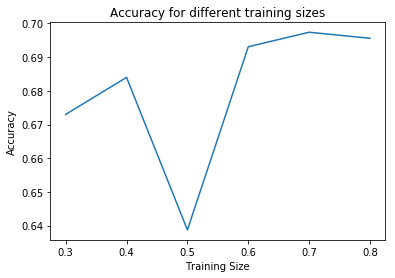

In [5]:
plt.plot(size_list , score_list)
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Accuracy for different training sizes')

__COMMENTS:__

In this part we can see that we have globally increasing performance (except for training size of 0.5 which must be a exception, like a bad initialisation of the weights). Indeed, our performance are not quite better with a bigger training size, at the end of the two epochs. This can be for one reason mainly. First, maybe as we've got ùany many detritus in our training set maybe we're just very likely to recognize detritus in with a less big data set.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting Plankton (taxonomy level 2) classes.

- Your submission will be the <b>HTML version of your notebook</b> exploring the various modelling aspects described above.

- At the end of the notebook you should indicate your final evaluation score on a held-out test set. As an evaluation metric you should use the F1 score with the *average=macro* option as it is provided by the scikit-learn library. See the following link for more information:
        
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [22]:
#FINAL SCORE WITH SKLEARN AVERAGE='MACRO'
print(score)

0.2804223586551583


<div class="">
    <h2>Dataset Description</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;"/>    
</div>

#### * Location of the Dataset on zoe
The data for this challenge is located at: `/mnt/datasets/plankton/flowcam`

#### * Hierachical Taxonomy Tree for Labels 

Each object is represented by a single image and is identified by a unique integer number. It has a name associated to it which is integrated in a hierarchical taxonomic tree. The identifications are gathered from different projects, classified by different people in different contexts, so they often target different taxonomic levels. For example, let us say we classify items of clothing along the following tree

    top
        shirt
            long sleeves
            short sleeves
        sweater
            hooded
            no hood
    bottom
        pants
            jeans
            other
        shorts
        
In a first project, images are classified to the finest level possible, but it may be the case that, on some pictures, it is impossible to determine whether a sweater has a hood or not, in which case it is simply classified as `sweater`. In the second project, the operator classified tops as `shirt` or `sweater` only, and bottoms to the finest level. In a third project, the operator only separated tops from bottoms. In such a context, the original names in the database cannot be used directly because, for example `sweater` will contain images that are impossible to determine as `hooded` or `no hood` *as well as* `hooded` and `no hood` images that were simply not classified further. If all three classes (`sweater`, `hooded`, and `no hood`) are included in the training set, it will likely confuse the classifier. For this reason, we define different target taxonomic levels:

-   `level1` is the finest taxonomic level possible. In the example above, we would include `hooded` and `no hood` but discard all images in `sweater` to avoid confusion; and proceed in the same manner for other classes.

-   `level2` is a grouping of underlying levels. In the example above, it would include `shirt` (which contains all images in `shirt`, `long sleeves`, and `short sleeves`), `sweater` (which, similarly would include this class and all its children), `pants` (including children), and `shorts`. So typically, `level2` contains more images (less discarding), sorted within fewer classes than `level1`, and may therefore be an easier classification problem.

-   `level3` is an even broader grouping. Here it would be `top` vs `bottom`

-   etc.

In the Plankton Image dataset, the objects will be categorised based on a pre-defined 'level1' and 'level2'. You can opt to work on one of them, but we recommend you to work on `level2` because it is an easier classification problem.  

#### * Data Structure

    /mnt/datasets/plankton/flowcam/
        meta.csv
        taxo.csv
        features_native.csv.gz
        features_skimage.csv.gz
        imgs.zip

* `meta.csv` contains the index of images and their corresponding labels
* `taxo.csv` defines the taxonomic tree and its potential groupings at various level. Note that, the information is also available in `meta.csv`. Therefore, the information in `taxo.csv` is probably useless, but at least it gives you a global view about taxonomy tree
* `features_native.csv.gz` contain the morphological handcrafted features computed by ZooProcess. In fact, ZooProcess generates the region of interests (ROI) around each individual object from a original image of Plankton. In addition, it also computes a set of associated features measured on the object. These features are the ones contained in `features_native.csv.gz`
* `features_skimage.csv.gz` contains the morphological features recomputed with skimage.measure.regionprops on the ROIs produced by ZooProcess.
* `imgs.zip` contains a post-processed version of the original images. Images are named by `objid`.jpg

#### * Attributes in meta.csv

The file contains the image identifiers (objid) as well as the labels assigned to the images by human operators. Those are defined with various levels of precision:

* <i>unique_name</i>: raw labels from operators
* <i>level1</i>: cleaned, most detailed labels
* <i>level2</i>: regrouped (coarser) labels
* <i>lineage</i>: full taxonomic lineage of the class

Some labels may be missing (coded ‘NA’) at a given level, meaning that the corresponding objects should be discarded for the classification at this level.

#### * imgs.zip

This zip archive contains an *imgs* folder that contains all the images in .jpg format. Do not extract this folder to disk! Instead you will be loading the images to memory. See the code below for a quick how-to:

#### * Attributes in features_native.csv.gz
A brief outline of the availabel attributes in `features_native.csv.gz` which you can use is given below:

* <i>objid</i>: same as in `meta.csv`
* <i>area</i>: area of ROI
* <i>meanimagegrey</i>:
* <i>mean</i>: mean grey
* <i>stddev</i>: standard deviation of greys
* <i>min</i>: minimum grey
* <i>perim.</i>: perimeter of ROI
* <i>width, height</i>: dimensions of ROI
* <i>major, minor</i>: length of major,minor axis of the best fitting ellipse
* <i>angle</i>: 
* <i>circ.</i>: circularity or shape factor which can be computed by 4pi(area/perim.^2)
* <i>feret</i>:  maximal feret diameter
* <i>intden</i>: integrated density: mean*area
* <i>median</i>: median grey
* <i>skew, kurt</i>: skewness,kurtosis of the histogram of greys
* <i>%area</i>: proportion of the image corresponding to the object
* <i>area_exc</i>: area excluding holes
* <i>fractal</i>: fractal dimension of the perimeter
* <i>skelarea</i>: area of the one-pixel wide skeleton of the image ???
* <i>slope</i>: slope of the cumulated histogram of greys
* <i>histcum1, 2, 3</i>:  grey level at quantiles 0.25, 0.5, 0.75 of the histogram of greys
* <i>nb1, 2, 3</i>: number of objects after thresholding at the grey levels above
* <i>symetrieh, symetriev</i>: index of horizontal,vertical symmetry
* <i>symetriehc, symetrievc</i>: same but after thresholding at level histcum1
* <i>convperim, convarea</i>: perimeter,area of the convex hull of the object
* <i>fcons</i>: contrast
* <i>thickr</i>: thickness ratio: maximum thickness/mean thickness
* <i>esd</i>:
* <i>elongation</i>: elongation index: major/minor
* <i>range</i>: range of greys: max-min
* <i>meanpos</i>:  relative position of the mean grey: (max-mean)/range
* <i>centroids</i>:
* <i>cv</i>: coefficient of variation of greys: 100*(stddev/mean)
* <i>sr</i>: index of variation of greys: 100*(stddev/range)
* <i>perimareaexc</i>:
* <i>feretareaexc</i>:
* <i>perimferet</i>: index of the relative complexity of the perimeter: perim/feret
* <i>perimmajor</i>: index of the relative complexity of the perimeter: perim/major
* <i>circex</i>:
* <i>cdexc</i>:
* <i>kurt_mean</i>:
* <i>skew_mean</i>:
* <i>convperim_perim</i>:
* <i>convarea_area</i>:
* <i>symetrieh_area</i>:
* <i>symetriev_area</i>:
* <i>nb1_area</i>:
* <i>nb2_area</i>:
* <i>nb3_area</i>:
* <i>nb1_range</i>:
* <i>nb2_range</i>:
* <i>nb3_range</i>:
* <i>median_mean</i>:
* <i>median_mean_range</i>:
* <i>skeleton_area</i>:

#### * Attributes in features_skimage.csv.gz
Table of morphological features recomputed with skimage.measure.regionprops on the ROIs produced by ZooProcess. See http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops for documentation.

https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/

https://www.irjet.net/archives/V4/i12/IRJET-V4I12123.pdf

https://www.sciencedirect.com/topics/engineering/image-classification

https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/